### Carregando dados:

In [22]:
import pickle

with open('features_tratadas/critic_temp.pkl', 'rb') as f:
    crit_temp_array = pickle.load(f)
with open('features_tratadas/atomic_mass.pkl', 'rb') as f:
    atomic_mass_array = pickle.load(f)
with open('features_tratadas/fie.pkl', 'rb') as f:
    fie_array = pickle.load(f)
with open('features_tratadas/atom_radius.pkl', 'rb') as f:
    atom_radius_array = pickle.load(f)
with open('features_tratadas/density.pkl', 'rb') as f:
    density_array = pickle.load(f)
with open('features_tratadas/elec_aff.pkl', 'rb') as f:
    elec_aff_array = pickle.load(f)
with open('features_tratadas/fusion_heat.pkl', 'rb') as f:
    fusion_heat_array = pickle.load(f)
with open('features_tratadas/thermal_cond.pkl', 'rb') as f:
    thermal_cond_array = pickle.load(f)
with open('features_tratadas/valence.pkl', 'rb') as f:
    valence_array = pickle.load(f)

### Separando em train - test:

In [23]:
from sklearn.model_selection import train_test_split

crit_temp_array_train, crit_temp_array_test = train_test_split(crit_temp_array, test_size=0.2, random_state=42)
atomic_mass_array_train, atomic_mass_array_test = train_test_split(atomic_mass_array, test_size=0.2, random_state=42)
fie_array_train, fie_array_test = train_test_split(fie_array, test_size=0.2, random_state=42)
atom_radius_array_train, atom_radius_array_test = train_test_split(atom_radius_array, test_size=0.2, random_state=42)
density_array_train, density_array_test = train_test_split(density_array, test_size=0.2, random_state=42)
elec_aff_array_train, elec_aff_array_test = train_test_split(elec_aff_array, test_size=0.2, random_state=42)
fusion_heat_array_train, fusion_heat_array_test = train_test_split(fusion_heat_array, test_size=0.2, random_state=42)
thermal_cond_array_train, thermal_cond_array_test = train_test_split(thermal_cond_array, test_size=0.2, random_state=42)
valence_array_train, valence_array_test = train_test_split(valence_array, test_size=0.2, random_state=42)

### Preparando dados em formato tensor:

In [24]:
import torch
from sklearn.preprocessing import StandardScaler
import numpy as np

X_train = np.column_stack(
    [atomic_mass_array_train, fie_array_train, atom_radius_array_train, density_array_train, 
    elec_aff_array_train, fusion_heat_array_train, thermal_cond_array_train, valence_array_train]
)
Y_train = crit_temp_array_train.reshape(-1, 1)

# Normalização:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
Y_train = scaler_Y.fit_transform(Y_train)

# Convertendo para tensores:
X_tensor_train = torch.tensor(X_train, dtype=torch.float32)
Y_tensor_train = torch.tensor(Y_train, dtype=torch.float32)

### Criando modelo com Pytorch - nn.Module:

In [25]:
import torch.nn as nn
import torch.optim as optim

class RedeNeural(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

modelo = RedeNeural(input_dim=8)

funcao_perda = nn.MSELoss()
otimizador = optim.Adam(modelo.parameters(), lr=0.001)

### Treinando a rede:

In [26]:
best_loss = float('inf')
epocas_estagnadas = 0
patience = 20
min_delta = 1e-4

epocas = 5000
for epoca in range(epocas):
    modelo.train()
    otimizador.zero_grad()
    output = modelo(X_tensor_train)
    loss = funcao_perda(output, Y_tensor_train)
    loss.backward()
    otimizador.step()
    
    # Verifica se o treinamento está estagnado:
    if best_loss - loss.item() > min_delta:
        best_loss = loss.item()
        epocas_estagnadas = 0
    else:
        epocas_estagnadas += 1

    # Imprime época e a perda:
    if (epoca + 1) % 100 == 0:
        print(f"Época {epoca+1}, Perda: {loss.item():.6f}")

    # Dá um break se estiver estagnado:
    if epocas_estagnadas >= patience:
        print(f"Early stopping na época {epoca+1}")
        break

Época 100, Perda: 0.321623
Época 200, Perda: 0.260321
Época 300, Perda: 0.224696
Época 400, Perda: 0.207165
Época 500, Perda: 0.197874
Época 600, Perda: 0.190170
Early stopping na época 666


### Testando Acurácia do modelo:

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_test = np.column_stack([
    atomic_mass_array_test,
    fie_array_test,
    atom_radius_array_test,
    density_array_test,
    elec_aff_array_test,
    fusion_heat_array_test,
    thermal_cond_array_test,
    valence_array_test
])
Y_test = crit_temp_array_test.reshape(-1, 1)

# Normalização:
X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)

# Transformando em tensores:
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_scaled, dtype=torch.float32)

# Coloca o modelo em modo de avaliação
modelo.eval()

with torch.no_grad():
    Y_pred_test = modelo(X_test_tensor)

# Reverte a transformação (raiz quadrada) → escala real (Kelvin):
Y_real_test = scaler_Y.inverse_transform(Y_test_tensor.numpy()) ** 2
Y_pred_test = scaler_Y.inverse_transform(Y_pred_test.numpy()) ** 2

# Corrige valores negativos
Y_pred_test = np.where(Y_pred_test < 0, 0, Y_pred_test) # Zera valores negativos previstos

# Calcula as métricas na escala Kelvin:
mae_test = mean_absolute_error(Y_real_test, Y_pred_test)
rmse_test = np.sqrt(mean_squared_error(Y_real_test, Y_pred_test))
r2_test = r2_score(Y_real_test, Y_pred_test)

print(f"MAE (real): {mae_test:.2f} K")
print(f"RMSE (real): {rmse_test:.2f} K")
print(f"R² (real): {r2_test:.4f}")

MAE (real): 10.17 K
RMSE (real): 15.25 K
R² (real): 0.7980


### Plotando gráfico de comparação:

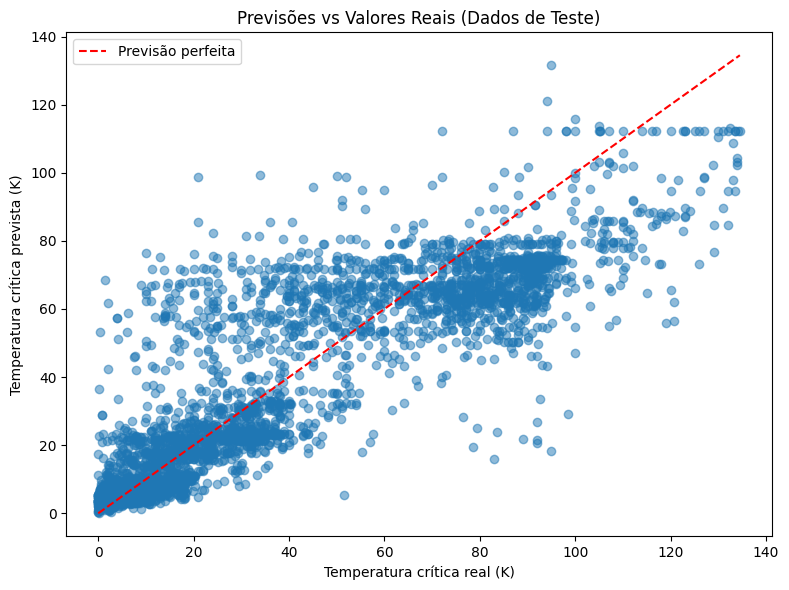

In [28]:
import matplotlib.pyplot as plt

# Plotando gráfico de comparação:
plt.figure(figsize=(8, 6))
plt.scatter(Y_real_test, Y_pred_test, alpha=0.5)
plt.plot([Y_real_test.min(), Y_real_test.max()],
         [Y_real_test.min(), Y_real_test.max()],
         color='red', linestyle='--', label='Previsão perfeita')

plt.xlabel("Temperatura crítica real (K)")
plt.ylabel("Temperatura crítica prevista (K)")
plt.title("Previsões vs Valores Reais (Dados de Teste)")
plt.legend()
plt.tight_layout()
plt.show()